In [1]:
setwd('/fs/cbcb-lab/rob/students/noor/Uncertainity/treeTerminusScripts')
dir <- "environment/Chimp/mode=gcbias/post_type=gibbs_nrep=100_tf=100/tree_analysis"
term_dir <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/ChimpData/term_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100"
suppressPackageStartupMessages(source("tree_helper_function.R"))
suppressPackageStartupMessages(source("old_terminus_helper.R"))
suppressPackageStartupMessages(library(latex2exp))
suppressPackageStartupMessages(library(ggplot2))
load("environment/Chimp/mapDf.RData")
load(file.path(dir, "treeCons.RData"))
load(file.path(dir, "yAggConsNS.RData"))
load(file.path(dir, "treeCor.RData"))
load(file.path(dir, "yAggCorNS.RData"))
load(file.path(dir, "treeCons0.RData"))
load(file.path(dir, "yAggConsNS0.RData"))
load(file.path(dir, "treeMeanInf0.RData"))
load(file.path(dir, "yAggMeanInfNS0.RData"))
load(file.path(dir, "treeThr.RData"))
load(file.path(dir, "yAggThrNS.RData"))
load(file.path(dir, "yAggTermThrNS.RData"))
suppressPackageStartupMessages(source("brain_simulation_nodtu/mode=gc_bias/post_type=gibbs_nrep=100_tf=100/tree_analysis/tree_filter.R"))

In [2]:
suppressPackageStartupMessages(library(beaveR))

In [3]:
suppressPackageStartupMessages(library(latex2exp))

In [10]:
dfTPMLFC <- data.frame(matrix(nrow=0, ncol=3))
colnames(dfTPMLFC) <- c("Type", "Value", "nCuts")

l <- length(treeCons$tip)
trees <- list(treeCons, treeCons0, treeMeanInf0, treeCor, treeThr)
names(trees) <- c("ConsFilt", "Cons", "Mean", "AC", "ConsFiltES")
yAgg <- list(yAggConsNS, yAggConsNS0, yAggMeanInfNS0, yAggCorNS, yAggThrNS, yAggTermThrNS)
names(yAgg) <- c("ConsFilt", "Cons", "Mean", "AC", "ConsFiltES", "Term")

dCutsTPM <- vector(mode = "list", length=7)
names(dCutsTPM) <- c(names(yAgg), "Txps")

cutsTPM <- list()
for(n in names(yAgg)) {
    if(n != "Term") {
        trees[[n]]$node.label <- as.character(length(trees[[n]]$tip) + 1:trees[[n]]$Nnode)
        tse <- TreeSummarizedExperiment(assays = assays(yAgg[[n]]), colData = colData(yAgg[[n]]),
            metadata = metadata(yAgg[[n]]), rowTree = trees[[n]])
        descL <- sapply(Descendants(trees[[n]], seq(l+trees[[n]]$Nnode)), length)
        sLFC <- getTPMLFC(tse, "condition")
        met <- abs(sLFC)*descL
        objS <- solveForOptimalCut(tse, metVec = met, type = 'max')
        dCutsTPM[[n]] <- objS[["cut"]]
        df <- data.frame(Type = n, Value = objS[["optVal"]], 
                         nCuts = length(dCutsTPM[[n]]))
        dfTPMLFC <- rbind(dfTPMLFC, df)
        if(n == "ConsFiltES") {
            df <- data.frame(Type = "Txps", Value = sum(abs(met[1:l])), 
                         nCuts = l)
            dfTPMLFC <- rbind(dfTPMLFC, df)
        }
    }
        
    else {
        groupsClust <- parseClustFile(file.path(term_dir, "old", "PTB162LA1C", "clusters.txt"), yAggTermThrNS, gsub=T)
        mtxps <- setdiff(seq(l), unlist(groupsClust))
        dCutsTPM[[n]] <- c(mtxps, l+1:length(groupsClust))
        descL <- c(rep(1, length(mtxps)), sapply(groupsClust, length))
        infReps <- assays(yAgg[[n]])[grep("infRep", assayNames(yAgg[[n]]))]
        infReps <- abind::abind(as.list(infReps), along = 3)
        mSf <- 0
        for(j in seq(dim(infReps)[3])) {
                sf <- colSums(infReps[1:l,,j])
                mSf <- mean(sf) + mSf
                infReps[,,j] <- t(t(infReps[,,j])/sf)
        }
        mSf <- mSf/dim(infReps)[3]
        
        lfc <- getLog2FC(infReps, colData(yAgg[[n]])[["condition"]], pc = 5/mSf)
        
        df <- data.frame(Type = n, Value = sum(abs(lfc[dCutsTPM[[n]]])*descL), 
                         nCuts = length(dCutsTPM[[n]]))
        dfTPMLFC <- rbind(dfTPMLFC, df)
    }
}
print(dfTPMLFC)
saveDir <- "environment/Chimp/mode=gcbias/post_type=gibbs_nrep=100_tf=100/tree_analysis/"
save(dfTPMLFC, file=file.path(saveDir, "dfTPMLFC.RData"))
save(dCutsTPM, file=file.path(saveDir, "dCutsTPM.RData"))

        Type    Value nCuts
1   ConsFilt 31299.65 26234
2       Cons 31734.43 25243
3       Mean 31667.99 25161
4         AC 31476.45 27135
5 ConsFiltES 25163.61 39309
6       Txps 23111.25 45375
7       Term 23025.77 42366


In [3]:
saveDir <- "environment/Chimp/mode=gcbias/post_type=gibbs_nrep=100_tf=100/tree_analysis/"
load(file=file.path(saveDir, "dCutsTPM.RData"))

In [ ]:
l <- length(treeCons$tip)
trees <- list(treeCons, treeCons0, treeMeanInf0, treeCor, treeThr)
names(trees) <- c("ConsFilt", "Cons", "Mean", "AC", "ConsFiltES")
yAgg <- list(yAggConsNS, yAggConsNS0, yAggMeanInfNS0, yAggCorNS, yAggThrNS, yAggTermThrNS)
names(yAgg) <- c("ConsFilt", "Cons", "Mean", "AC", "ConsFiltES", "Term")


dfTPMLFCDist <- data.frame(matrix(nrow=0, ncol=2))
colnames(dfTPMLFCDist) <- c("Value", "Type")
for(i in seq_along(trees)) {
    trees[[i]]$node.label <- as.character(length(trees[[i]]$tip) + 1:trees[[i]]$Nnode)
    tse <- TreeSummarizedExperiment(assays = assays(yAgg[[i]]), colData = colData(yAgg[[i]]),
            metadata = metadata(yAgg[[i]]), rowTree = trees[[i]])
    descL <- sapply(Descendants(trees[[i]], seq(l+trees[[i]]$Nnode)), length)
    sLFC <- getTPMLFC(tse, "condition")
    optVal <- abs(sLFC)*descL
    dfTPMLFCDist <- rbind(dfTPMLFCDist, data.frame(Value = optVal[dCutsTPM[[i]]], Type = names(trees)[i]))
}

In [ ]:
term_dir <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/ChimpData/term_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/old"
groupsClust <- parseClustFile(file.path(term_dir, "PTB162LA1C", "clusters.txt"), yAggTermThrNS, gsub=T)mtxps <- setdiff(seq(l), unlist(groupsClust))
mInds <- seq(l + length(groupsClust))
descL <- c(rep(1, length(mtxps)), sapply(groupsClust, length))
n <- "Term"
infReps <- assays(yAgg[[n]])[grep("infRep", assayNames(yAgg[[n]]))]
infReps <- abind::abind(as.list(infReps), along = 3)
mSf <- 0
for(j in seq(dim(infReps)[3])) {
        sf <- colSums(infReps[1:l,,j])
        mSf <- mean(sf) + mSf
        infReps[,,j] <- t(t(infReps[,,j])/sf)
}
mSf <- mSf/dim(infReps)[3]

tpmLFC <- getLog2FC(infReps, colData(yAgg[[n]])[["condition"]], pc = 5/mSf)
dfTPMLFCDist <- rbind(dfTPMLFCDist, data.frame(Value = abs(tpmLFC[dCutsTPM[[n]]])*descL, Type = n))
dfTPMLFCDist <- rbind(dfTPMLFCDist, data.frame(Value = abs(tpmLFC[1:l]), Type = "Txps"))
save(dfTPMLFCDist, file = file.path(saveDir, "dfLLTPM.RData"))

In [ ]:
size <- 20
ggplot(dfTPMLFCDist, aes(x=log2(Value), fill = Type, colour = Type)) + 
    geom_density(position = "dodge", alpha=0.1) +
    theme_bw() +
    labs(fill="Type", color="Type") +
    xlab(TeX("$log_{2}$(Value of Metric)")) +
    ggtitle("BrSimNorm Dataset") +
    theme(axis.title = element_text(size = size),
    plot.title = element_text(size = size + 1, hjust=0.5),
    axis.text = element_text(size = size),
    legend.text = element_text(size = size),
    legend.title = element_text(size = size))

In [15]:
globArr <- rep(-100, l+trees[[i]]$Nnode)
descL <- sapply(Descendants(trees[[i]], seq(l+trees[[i]]$Nnode)), length)
infReps <- assays(yAgg[[i]])[grep("infRep", assayNames(yAgg[[i]]))]
infReps <- abind::abind(as.list(infReps), along = 3)

In [70]:
infReps <- assays(yAggConsNS)[grep("infRep", assayNames(yAggConsNS))]
infReps <- abind::abind(as.list(infReps), along = 3)
iReps <- infReps
mSf <- 0
for(i in seq(dim(infReps)[3])) {
        sf <- colSums(infReps[1:l,,i])
        mSf <- mean(sf) + mSf
        iReps[,,i] <- t(t(infReps[,,i])/sf)
}
mSf <- mSf/dim(inReps)[3]

In [71]:
lfc <- getLog2FC(iReps, colData(yAggConsNS)[["condition"]], pc = 5/mSf)

In [76]:
obj <- abs(lfc)/mcols(yAggConsNS)[["meanInfRV"]]

In [79]:
globArr <- rep(-100, l+treeCons$Nnode)
descL <- sapply(Descendants(treeCons, seq(l+treeCons$Nnode)), length)
val <- findMaxSum(treeCons, obj, l+1, descL)

In [83]:
globArr[l+1]
obj[l+1]*descL[l+1]

[1] 535524.4

45376 
    0

In [86]:
cuts <- findCuts(treeCons, globArr, obj, l+1, descL)

In [43]:
dfScaledLFC <- data.frame(matrix(nrow=0, ncol=3))
colnames(dfScaledLFC) <- c("Type", "Value", "nCuts")

l <- length(treeCons$tip)
trees <- list(treeCons, treeCons0, treeMeanInf0, treeCor, treeThr)
names(trees) <- c("ConsInd", "Cons", "Mean", "AC", "ConsRedInd")
yAgg <- list(yAggConsNS, yAggConsNS0, yAggMeanInfNS0, yAggCorNS, yAggThrNS, yAggTermThrNS)
names(yAgg) <- c("ConsInd", "Cons", "Mean", "AC", "ConsRedInd", "Term")

dCutsSLFC <- vector(mode = "list", length=7)
names(dCutsSLFC) <- c(names(yAgg), "Txps")
for(i in seq_along(yAgg)) {
    globArr <- rep(-100, l+trees[[i]]$Nnode)
    if(i <= 5)
        descL <- sapply(Descendants(trees[[i]], seq(l+trees[[i]]$Nnode)), length)
    else {
        groupsClust <- parseClustFile(file.path(term_dir, "old", "PTB162LA1C", "clusters.txt"), yAggTermThrNS, gsub=T)
        mtxps <- setdiff(seq(l), unlist(groupsClust))
        dCutsSLFC[[i]] <- c(mtxps, l+1:length(groupsClust))
        descL <- c(rep(1, length(mtxps)), sapply(groupsClust, length))
    }
        
    infReps <- assays(yAgg[[i]])[grep("infRep", assayNames(yAgg[[i]]))]
    infReps <- abind::abind(as.list(infReps), along = 3)
    mSf <- 0
    for(j in seq(dim(infReps)[3])) {
            sf <- colSums(infReps[1:l,,j])
            mSf <- mean(sf) + mSf
            infReps[,,j] <- t(t(infReps[,,j])/sf)
    }
    mSf <- mSf/dim(infReps)[3]
    print(mSf)
    lfc <- getLog2FC(infReps, colData(yAgg[[i]])[["condition"]], pc = 5/mSf)
    obj <- abs(lfc)/mcols(yAgg[[i]])[["meanInfRV"]]
    if (i==6)         
        val <- sum(obj[dCutsSLFC[[i]]]*descL)

    else {
            val <- findMaxSum(trees[[i]], obj, l+1, descL)
            gc()
            dCutsSLFC[[i]] <- findCuts(trees[[i]], globArr, obj, l+1, descL)
            gc()
    }
    
    dfScaledLFC <- rbind(dfScaledLFC, data.frame(Type = names(yAgg)[i], Value = val,
           nCuts = length(dCutsSLFC[[i]])))

}
i <- 7
dCutsSLFC[[i]] <- 1:l
val <- sum(obj[dCutsSLFC[[i]]])
dfScaledLFC <- rbind(dfScaledLFC, data.frame(Type = "Txp", Value = val,
           nCuts = length(dCutsSLFC[[i]])))
print(dfScaledLFC)
save(dfScaledLFC, file=file.path(dir, "dfScaledLFC.RData"))
save(dCutsSLFC, file=file.path(dir, "dCutsSLFC.RData"))

        Type    Value nCuts
1    ConsInd 535524.4 19419
2       Cons 549330.8 18343
3       Mean 551447.8 18138
4         AC 488901.2 19508
5 ConsRedInd 247252.8 35762
6       Term 167713.2 42366
7        Txp 148522.2 45375


In [2]:
load(file.path(dir, "dfInf.RData"))
load(file.path(dir, "dCutsDInf.RData"))
load(file.path(dir, "dCutsSLFC.RData"))
names(dCutsSLFC)
names(dCutsDInf[[1]])

[1] "ConsInd"    "Cons"       "Mean"       "AC"         "ConsRedInd"
[6] "Term"       "Txp"

[1] "ConsInd"    "Cons"       "Mean"       "AC"         "ConsRedInd"
[6] "Txps"

In [35]:
nn <- c("ConsFilt", "Cons", "Mean", "AC", "ConsFiltES")
trees <- list(treeCons, treeCons0, treeMeanInf0, treeCor, treeThr)
names(trees) <- nn
yAgg <- list(yAggConsNS, yAggConsNS0, yAggMeanInfNS0, yAggCorNS, yAggThrNS)
names(yAgg) <- nn

In [43]:
# l <- length(treeCons$tip)
# gammas <- c(0.1,0.5,1,5,10)
# objsLFC <- vector(mode="list", length(yAgg))
# names(objsLFC) <- names(yAgg)
# objsDepth <- vector(mode="list", length(yAgg))
# names(objsDepth) <- names(yAgg)
# for(i in seq_along(yAgg)) {
#     descL <- sapply(Descendants(trees[[i]],seq(l+trees[[i]]$Nnode)),length)
#     objsDepth[[i]] <- (mcols(yAgg[[i]])[["meanInfRV"]] + 0.1*node.depth(trees[[i]],2))*descL
#     infReps <- assays(yAgg[[i]])[grep("infRep", assayNames(yAgg[[i]]))]
#     infReps <- abind::abind(as.list(infReps), along = 3)
#     mSf <- 0
#     for(j in seq(dim(infReps)[3])) {
#             sf <- colSums(infReps[1:l,,j])
#             mSf <- mean(sf) + mSf
#             infReps[,,j] <- t(t(infReps[,,j])/sf)
#     }
#     mSf <- mSf/dim(infReps)[3]
#     print(mSf)
#     lfc <- getLog2FC(infReps, colData(yAgg[[i]])[["condition"]], pc = 5/mSf)
#     objsLFC[[i]] <- descL*abs(lfc)/mcols(yAgg[[i]])[["meanInfRV"]]
# }

suppressPackageStartupMessages(source("old_terminus_helper.R"))
i <- 6
infReps <- assays(yAggTermThrNS)[grep("infRep", assayNames(yAggTermThrNS))]
infReps <- abind::abind(as.list(infReps), along = 3)
term_dir <- "/fs/cbcb-lab/rob/students/noor/Uncertainity/ChimpData/term_out/mode_gcbias=True/posttype=gibbs_npost=100_tf=100/old"
groupsClust <- parseClustFile(file.path(term_dir, "PTB162LA1C", "clusters.txt"), yAggTermThrNS, gsub=T)
mtxps <- setdiff(seq(l), unlist(groupsClust))

mSf <- 0
for(j in seq(dim(infReps)[3])) {
            sf <- colSums(infReps[1:l,,j])
            mSf <- mean(sf) + mSf
            infReps[,,j] <- t(t(infReps[,,j])/sf)
    }
mSf <- mSf/dim(infReps)[3]
descL <- c(rep(1, l), sapply(groupsClust, length))


lfc <- getLog2FC(infReps, colData(yAggTermThrNS)[["condition"]], pc = 5/mSf)
objsLFC[[i]] <- descL*abs(lfc)/mcols(yAggTermThrNS)[["meanInfRV"]]
names(objsLFC)[i] <- "Term"

In [42]:
length(groupsClust)

[1] 2419

#### Depth

In [37]:
for(i in seq(trees)){
    print(names(trees)[i])
    print(table(node.depth(trees[[i]],2)[dCutsDInf[[1]][[i]]])/length(dCutsDInf[[1]][[i]]))
}

[1] "ConsFilt"

           1            2            3            4            5            6 
6.319984e-01 1.706714e-01 1.043973e-01 5.080487e-02 2.261484e-02 1.036514e-02 
           7            8            9           10           11           12 
4.986258e-03 1.963094e-03 1.256380e-03 7.852375e-04 3.926188e-05 7.852375e-05 
          13 
3.926188e-05 
[1] "Cons"

           1            2            3            4            5            6 
6.352326e-01 1.719767e-01 9.887597e-02 5.023256e-02 2.228682e-02 1.085271e-02 
           7            8            9           10           11           13 
5.775194e-03 2.286822e-03 1.317829e-03 9.689922e-04 7.751938e-05 7.751938e-05 
          14 
3.875969e-05 
[1] "Mean"

           1            2            3            4            5            6 
6.356634e-01 1.722790e-01 9.838984e-02 5.054962e-02 2.140424e-02 1.087630e-02 
           7            8            9           10           11           12 
5.534913e-03 2.554575e-03 1.586933e

Warning message:
"Width not defined. Set with `position_dodge(width = ?)`"


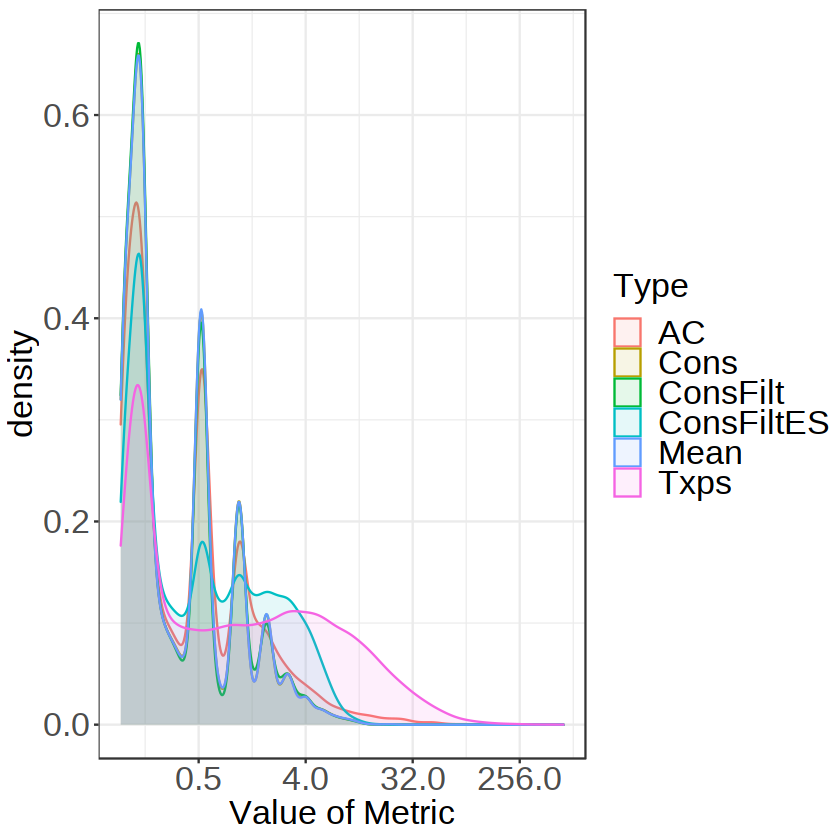

In [38]:
i <- 1
dfDepth <- data.frame(depthObj = objsDepth[[i]][dCutsDInf[[1]][[i]]], type=names(objsDepth)[i])
for(i in seq(2,5)) {
    dfDepth <- rbind(dfDepth, data.frame(depthObj = objsDepth[[i]][dCutsDInf[[1]][[i]]], type=names(objsDepth)[i]))
}
size <- 20
dfDepth <- rbind(dfDepth, data.frame(depthObj = objsDepth[[i]][1:l], type="Txps"))
pBr <- ggplot(dfDepth, aes(x=depthObj, fill = type, colour = type)) + 
    geom_density(position = "dodge", alpha=0.1) +
    theme_bw() +
    scale_x_continuous(trans="log2") +
    labs(fill="Type", color="Type") +
    xlab("Value of Metric") +
    theme(axis.title = element_text(size = size),
    plot.title = element_text(size = size + 1, hjust=0.5),
    axis.text = element_text(size = size),
    legend.text = element_text(size = size),
    legend.title = element_text(size = size))
pBr

#### LFC

[1] "ConsInd"

           1            2            3            4            5            6 
4.251506e-01 2.442968e-01 1.619548e-01 8.584376e-02 4.341109e-02 2.075287e-02 
           7            8            9           10           11           12 
8.393841e-03 5.510067e-03 2.214326e-03 1.905350e-03 2.574798e-04 1.029919e-04 
          13           14 
1.544879e-04 5.149596e-05 
[1] "Cons"

           1            2            3            4            5            6 
0.3746933435 0.2616256883 0.1684021152 0.0890257864 0.0483018045 0.0286212724 
           7            8            9           10           11           12 
0.0132475604 0.0069781388 0.0051245707 0.0029439023 0.0003816170 0.0002725835 
          13           14           15 
0.0001090334 0.0001635501 0.0001090334 
[1] "Mean"

           1            2            3            4            5            6 
3.596868e-01 2.707575e-01 1.703606e-01 9.157570e-02 4.846179e-02 2.751130e-02 
           7            8            

Warning message:
"Width not defined. Set with `position_dodge(width = ?)`"


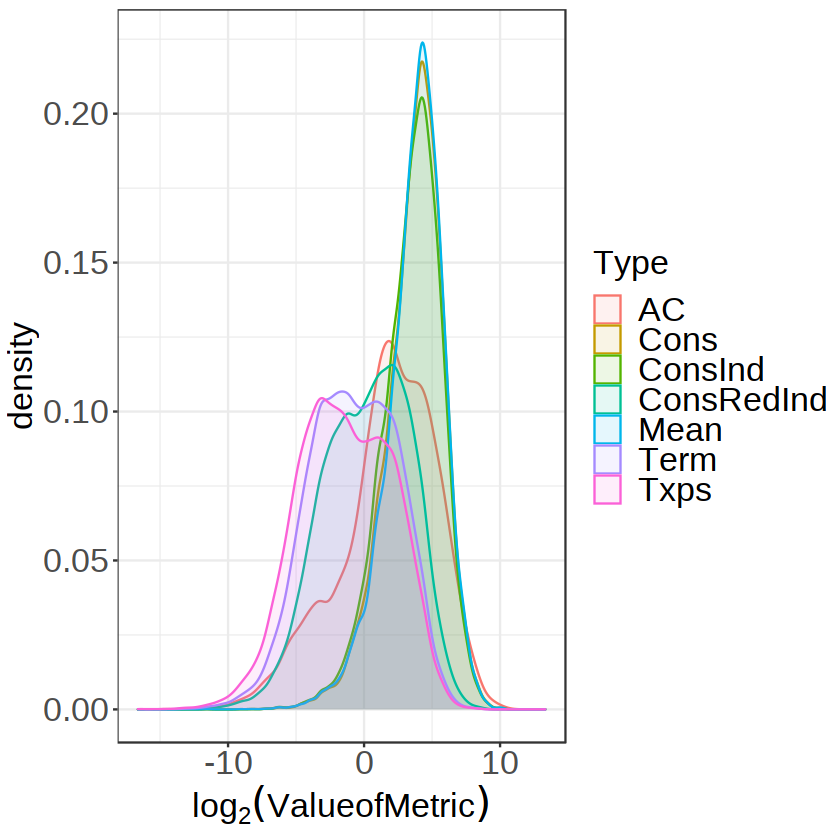

In [30]:
for(i in seq(trees)){
    print(names(trees)[i])
    print(table(node.depth(trees[[i]],2)[dCutsSLFC[[i]]])/length(dCutsSLFC[[i]]))
}
i <- 1
dfLFC <- data.frame(LFC = objsLFC[[i]][dCutsSLFC[[i]]], type=names(objsLFC)[i])
for(i in seq(2,6)) {
    dfLFC <- rbind(dfLFC, data.frame(LFC = objsLFC[[i]][dCutsSLFC[[i]]], type=names(objsLFC)[i]))
}
i <- 7
dfLFC <- rbind(dfLFC, data.frame(LFC = objsLFC[[i-1]][1:l], type="Txps"))
pBr <- ggplot(dfLFC, aes(x=log2(LFC), fill = type, colour = type)) + 
    geom_density(position = "dodge", alpha=0.1) +
    labs(fill="Type", color="Type") +
    xlab(TeX("$log_{2}(Value of Metric)$")) +
    theme_bw() +
    theme(axis.title = element_text(size = size),
    plot.title = element_text(size = size + 1, hjust=0.5),
    axis.text = element_text(size = size),
    legend.text = element_text(size = size),
    legend.title = element_text(size = size))
pBr

In [31]:
save(dfDepth, file=file.path(dir, "dfDe.RData"))
save(dfLFC, file=file.path(dir, "dfLL.RData"))